In [2]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN, convert_feature_into_cyclic
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def preprocess(data):
    indices = data.index

    data['HourOfDay'] = data['DateTime'].dt.hour
    data['DayOfWeek'] = data['DateTime'].dt.dayofweek
    data['Month'] = data['DateTime'].dt.month
    convert_feature_into_cyclic(data, 'HourOfDay', 24)
    convert_feature_into_cyclic(data, 'DayOfWeek', 7)
    convert_feature_into_cyclic(data, 'Month', 12)
    data.drop(columns=['HourOfDay', 'DayOfWeek', 'Month','NMHC(GT)'], inplace=True)
    # use fill forward imputation for 0 values
    data = data.replace(',', '.', regex=True)
    data['PT08.S1(CO)'] = data['PT08.S1(CO)'].mask(data['PT08.S1(CO)'] < 0, np.nan)
    data['PT08.S2(NMHC)'] = data['PT08.S2(NMHC)'].mask(data['PT08.S2(NMHC)'] < 0, np.nan)
    data['NOx(GT)'] = data['NOx(GT)'].mask(data['NOx(GT)'] < 0, np.nan)
    data['NO2(GT)'] = data['NO2(GT)'].mask(data['NO2(GT)'] < 0, np.nan)
    data['PT08.S4(NO2)'] = data['PT08.S4(NO2)'].mask(data['PT08.S4(NO2)'] < 0, np.nan)
    data['PT08.S5(O3)'] = data['PT08.S5(O3)'].mask(data['PT08.S5(O3)'] < 0, np.nan)
    data = data.ffill()
    # drop because of high correlation
    data = data.drop(columns=['PT08.S1(CO)','C6H6(GT)', 'PT08.S2(NMHC)'])
    data = data[data['PT08.S3(NOx)'] > 0]
    data = data.dropna()

    indices_after = data.index
    dropped_indices = set(indices) - set(indices_after)

    return data, dropped_indices

# Read in the data
raw_data = pd.read_csv('../csvs/AirQualityUCI.csv', sep=';')
raw_data['DateTime'] = raw_data['Time'] + '/' + raw_data['Date']
raw_data['DateTime'] = pd.to_datetime(raw_data['DateTime'], format='%H.%M.%S/%d/%m/%Y')
raw_data = raw_data.sort_values(by='DateTime').reset_index(drop=True)
raw_data.drop(columns=['Time', 'Date', 'Unnamed: 15', 'Unnamed: 16'], inplace=True)
# drop rows with all NaN values
raw_data.dropna(how='all', inplace=True)
preprocessed_data = preprocess(raw_data.copy())
print(raw_data.shape)
raw_data.head(n=100)

(9357, 14)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"2,9",1438.0,156.0,"12,0",1051.0,180.0,943.0,128.0,1668.0,1206.0,"21,3","30,8","0,7696",2004-03-14 17:00:00
96,"2,5",1478.0,122.0,"12,2",1055.0,160.0,929.0,121.0,1671.0,1262.0,"19,7","36,7","0,8307",2004-03-14 18:00:00
97,"4,6",1808.0,262.0,"20,6",1312.0,261.0,753.0,157.0,1993.0,1698.0,"18,4","41,7","0,8732",2004-03-14 19:00:00
98,"5,9",1898.0,341.0,"23,1",1381.0,325.0,681.0,173.0,2103.0,1905.0,"17,6","46,1","0,9210",2004-03-14 20:00:00


In [3]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)
descriptions = raw_data.drop(columns=['DateTime']).describe()
descriptions.rename(columns={'avg_temp_c': 'Average Temperature (C)'}, inplace=True)
descriptions.round(2).to_csv('../csv-descriptions/airquality-stats.csv')
descriptions

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
count,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00
mean,1048.99,-159.09,894.60,168.62,794.99,58.15,1391.48,975.07
std,329.83,139.79,342.33,257.43,321.99,126.94,467.21,456.94
min,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
25%,921.00,-200.00,711.00,50.00,637.00,53.00,1185.00,700.00
50%,1053.00,-200.00,895.00,141.00,794.00,96.00,1446.00,942.00
75%,1221.00,-200.00,1105.00,284.00,960.00,133.00,1662.00,1255.00
max,2040.00,1189.00,2214.00,1479.00,2683.00,340.00,2775.00,2523.00


In [4]:
split_index = int(len(raw_data) * 0.7)
raw_train = raw_data.copy()[:split_index]
raw_test = raw_data.copy()[split_index:]
preprocessed_train, dropped_indices = preprocess(raw_train.copy())

In [5]:
import pickle

In [15]:
dates = preprocessed_train['DateTime']
preprocessed_train = preprocessed_train.drop(columns=['DateTime'])

In [68]:
results_elman_h32 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=ElmanRNN(input_size=raw_train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)

(6401, 14)
(6401,)
(6338, 64, 14)
(6338,)
Train indices from 0 to 5070 and validation indices from 5071 to 6337


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x14 and 13x32)

In [59]:
results_jordan_h32 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=JordanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, state_size=32, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)



(6401, 14)
(6401,)
(6338, 64, 14)
(6338,)
Train indices from 0 to 5070 and validation indices from 5071 to 6337


KeyboardInterrupt: 

In [11]:
import pickle
pickle.dump(results_elman_h32, open('../pickles/airquality_results_elman_h32.pkl', 'wb'))
pickle.dump(results_jordan_h32, open('../pickles/airquality_results_jordan_h32.pkl', 'wb'))

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 753152.5495, Validation Loss: 604804.9525
Epoch [2/100], Loss: 614564.8440, Validation Loss: 482556.9814
Epoch [3/100], Loss: 484256.6081, Validation Loss: 381766.6912
Epoch [4/100], Loss: 379749.1480, Validation Loss: 302473.6420
Epoch [5/100], Loss: 295802.7500, Validation Loss: 241519.7001
Epoch [6/100], Loss: 229178.0433, Validation Loss: 195942.4617
Epoch [7/100], Loss: 176578.1023, Validation Loss: 163158.9761
Epoch [8/100], Loss: 134470.3753, Validation Loss: 139732.0099
Epoch [9/100], Loss: 107838.2592, Validation Loss: 124391.7538
Epoch [10/100], Loss: 88361.9241, Validation Loss: 114815.4378
Epoch [11/100], Loss: 71712.2646, Validation Loss: 102113.4436
Epoch [12/100], Loss: 66125.4587, Validation Loss: 90095.7715
Epoch [13/100], Loss: 53054.9650, Validation Loss: 80049.3535
Epoch [14/100], Loss: 42567.8714, Validation Loss: 73063.1131
Epoch [15

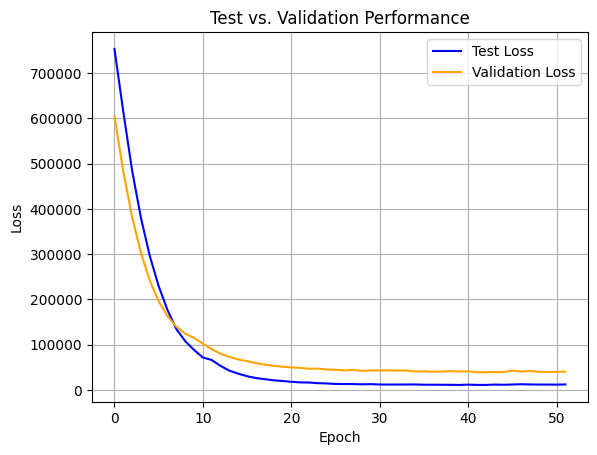

In [ ]:
results_elman_h64 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=ElmanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=64, output_size=1, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 629303.0947, Validation Loss: 363653.5178
Epoch [2/100], Loss: 220324.5394, Validation Loss: 137239.1770
Epoch [3/100], Loss: 78439.9042, Validation Loss: 111499.6650
Epoch [4/100], Loss: 55558.3649, Validation Loss: 110693.0078
Epoch [5/100], Loss: 48720.9238, Validation Loss: 101057.1836
Epoch [6/100], Loss: 41689.6302, Validation Loss: 81723.7508
Epoch [7/100], Loss: 33224.5688, Validation Loss: 70420.2438
Epoch [8/100], Loss: 25210.4134, Validation Loss: 60303.7679
Epoch [9/100], Loss: 22815.9083, Validation Loss: 57758.5430
Epoch [10/100], Loss: 19777.5996, Validation Loss: 54936.9853
Epoch [11/100], Loss: 20390.8691, Validation Loss: 51942.2600
Epoch [12/100], Loss: 19460.5700, Validation Loss: 50616.6768
Epoch [13/100], Loss: 18216.9690, Validation Loss: 49237.6839
Epoch [14/100], Loss: 17206.0354, Validation Loss: 47688.3758
Epoch [15/100], Loss: 

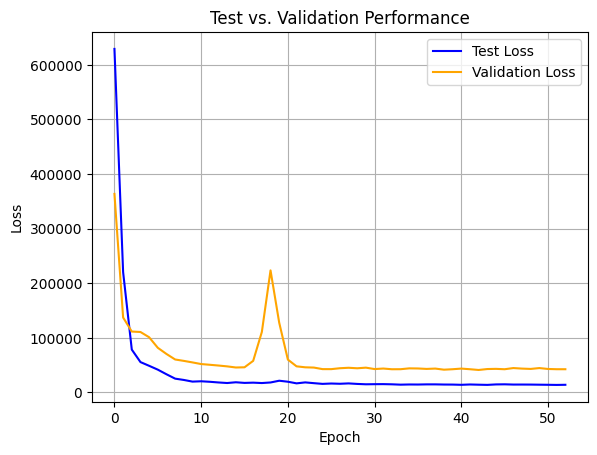

In [ ]:
results_jordan_h64 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=JordanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=64, output_size=1, state_size=32, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.05,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)



In [18]:
import pickle
pickle.dump(results_elman_h64, open('../pickles/airquality_results_elman_h64.pkl', 'wb'))
pickle.dump(results_jordan_h64, open('../pickles/airquality_results_jordan_h64.pkl', 'wb'))

In [6]:
airquality_jordan_h32_results = pickle.load(open('../pickles/airquality_results_jordan_h32.pkl', 'rb'))
airquality_elman_h32_results = pickle.load(open('../pickles/airquality_results_elman_h32.pkl', 'rb'))

In [6]:
processed_test, dropped_indices = preprocess(raw_test.copy())
processed_test.drop(columns=['DateTime'], inplace=True)
processed_test = processed_test.loc[~processed_test.index.isin(dropped_indices)]

(2590, 14)
(2590,)
(2527, 64, 14)
(2527,)
Train indices from 0 to 506 and validation indices from 507 to 1011
Epoch [1/70], Loss: 710089.6416, Validation Loss: 644485.4448, Squareroot of Validation Loss: 802.7985
Epoch [2/70], Loss: 702118.4854, Validation Loss: 637156.2178, Squareroot of Validation Loss: 798.2207
Epoch [3/70], Loss: 694773.3691, Validation Loss: 629252.2856, Squareroot of Validation Loss: 793.2542
Epoch [4/70], Loss: 686117.5000, Validation Loss: 621748.9912, Squareroot of Validation Loss: 788.5106
Epoch [5/70], Loss: 679668.4160, Validation Loss: 614477.3110, Squareroot of Validation Loss: 783.8860
Epoch [6/70], Loss: 672619.9722, Validation Loss: 607080.7988, Squareroot of Validation Loss: 779.1539
Epoch [7/70], Loss: 664565.6235, Validation Loss: 599557.7148, Squareroot of Validation Loss: 774.3111
Epoch [8/70], Loss: 656462.9624, Validation Loss: 592268.9302, Squareroot of Validation Loss: 769.5901
Epoch [9/70], Loss: 649948.3916, Validation Loss: 585143.7622, Squ

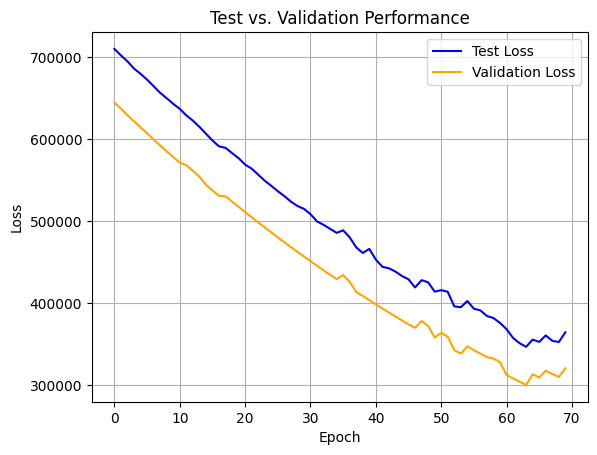

Train indices from 0 to 1011 and validation indices from 1012 to 1516
Epoch [1/70], Loss: 318706.1359, Validation Loss: 328197.7780, Squareroot of Validation Loss: 572.8855
Epoch [2/70], Loss: 294661.0754, Validation Loss: 326105.6604, Squareroot of Validation Loss: 571.0566
Epoch [3/70], Loss: 283871.9360, Validation Loss: 323872.9080, Squareroot of Validation Loss: 569.0983
Epoch [4/70], Loss: 276488.0516, Validation Loss: 327805.6075, Squareroot of Validation Loss: 572.5431
Epoch [5/70], Loss: 269397.0360, Validation Loss: 339495.9372, Squareroot of Validation Loss: 582.6628
Epoch [6/70], Loss: 290560.6670, Validation Loss: 351012.5378, Squareroot of Validation Loss: 592.4631
Epoch [7/70], Loss: 268439.0620, Validation Loss: 329110.7542, Squareroot of Validation Loss: 573.6818
Epoch [8/70], Loss: 257583.5041, Validation Loss: 307639.0349, Squareroot of Validation Loss: 554.6522
Epoch [9/70], Loss: 237521.0922, Validation Loss: 301586.2743, Squareroot of Validation Loss: 549.1687
Epo

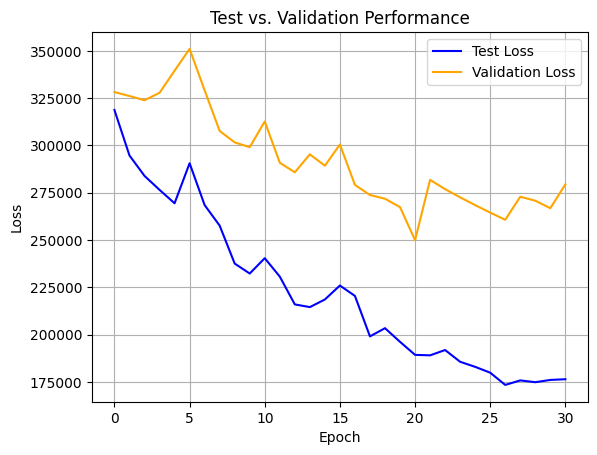

Train indices from 0 to 1516 and validation indices from 1517 to 2021
Epoch [1/70], Loss: 196555.8329, Validation Loss: 202150.0494, Squareroot of Validation Loss: 449.6110
Epoch [2/70], Loss: 183629.4105, Validation Loss: 186765.8199, Squareroot of Validation Loss: 432.1641
Epoch [3/70], Loss: 181155.9761, Validation Loss: 170947.3372, Squareroot of Validation Loss: 413.4578
Epoch [4/70], Loss: 175938.5970, Validation Loss: 165130.9997, Squareroot of Validation Loss: 406.3631
Epoch [5/70], Loss: 166685.1045, Validation Loss: 159755.2410, Squareroot of Validation Loss: 399.6939
Epoch [6/70], Loss: 164181.1899, Validation Loss: 154548.8514, Squareroot of Validation Loss: 393.1270
Epoch [7/70], Loss: 162264.2452, Validation Loss: 152768.1411, Squareroot of Validation Loss: 390.8557
Epoch [8/70], Loss: 156992.1400, Validation Loss: 145229.4179, Squareroot of Validation Loss: 381.0898
Epoch [9/70], Loss: 167462.5921, Validation Loss: 159860.1273, Squareroot of Validation Loss: 399.8251
Epo

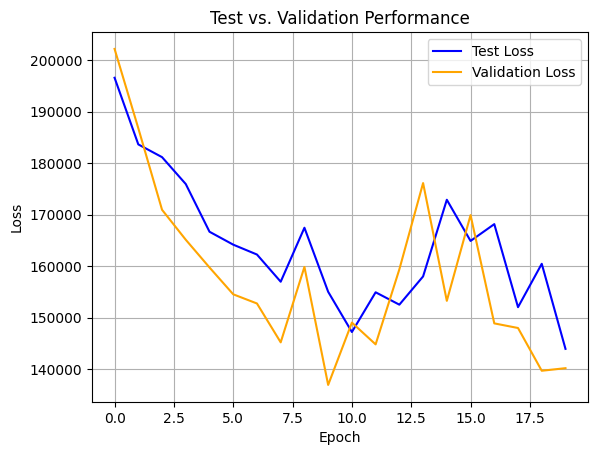

Train indices from 0 to 2021 and validation indices from 2022 to 2526
Epoch [1/70], Loss: 142105.6397, Validation Loss: 138948.9397, Squareroot of Validation Loss: 372.7586
Epoch [2/70], Loss: 161901.1368, Validation Loss: 132457.9073, Squareroot of Validation Loss: 363.9477
Epoch [3/70], Loss: 154487.8893, Validation Loss: 133937.2294, Squareroot of Validation Loss: 365.9744
Epoch [4/70], Loss: 138184.3878, Validation Loss: 132807.9402, Squareroot of Validation Loss: 364.4282
Epoch [5/70], Loss: 140600.8253, Validation Loss: 130923.5290, Squareroot of Validation Loss: 361.8336
Epoch [6/70], Loss: 143193.8183, Validation Loss: 132873.1897, Squareroot of Validation Loss: 364.5177
Epoch [7/70], Loss: 132794.0379, Validation Loss: 133726.8088, Squareroot of Validation Loss: 365.6868
Epoch [8/70], Loss: 143866.1939, Validation Loss: 131876.0874, Squareroot of Validation Loss: 363.1475
Epoch [9/70], Loss: 143647.4051, Validation Loss: 128103.4488, Squareroot of Validation Loss: 357.9154
Epo

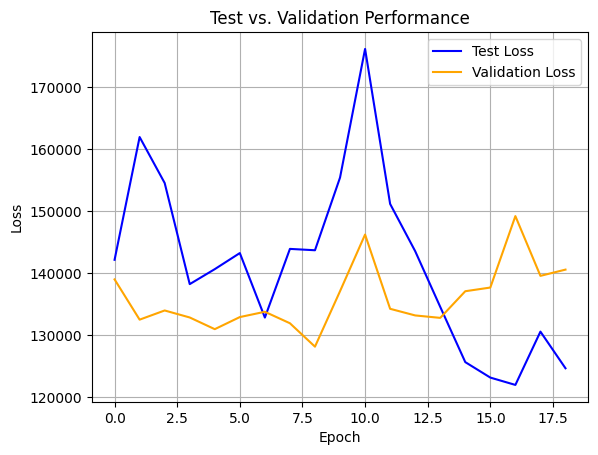

In [10]:
from util import MultiRecurrentNN
airquality_results_multirnn_h32 = training(data=processed_test,
         target_feature_name='PT08.S3(NOx)',
         model=MultiRecurrentNN(input_size=processed_test.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2, memory_config=[4,4,4]),
         num_epochs=70,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=False)

In [7]:
import pickle

In [ ]:

pickle.dump(airquality_results_multirnn_h32, open('../pickles/airquality_results_multirnn_h32.pkl', 'wb'))

NameError: name 'airquality_results_multirnn_h32' is not defined

In [8]:
airquality_results_multirnn_h32 = pickle.load(open('../pickles/airquality_results_multirnn_h32.pkl', 'rb'))

/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


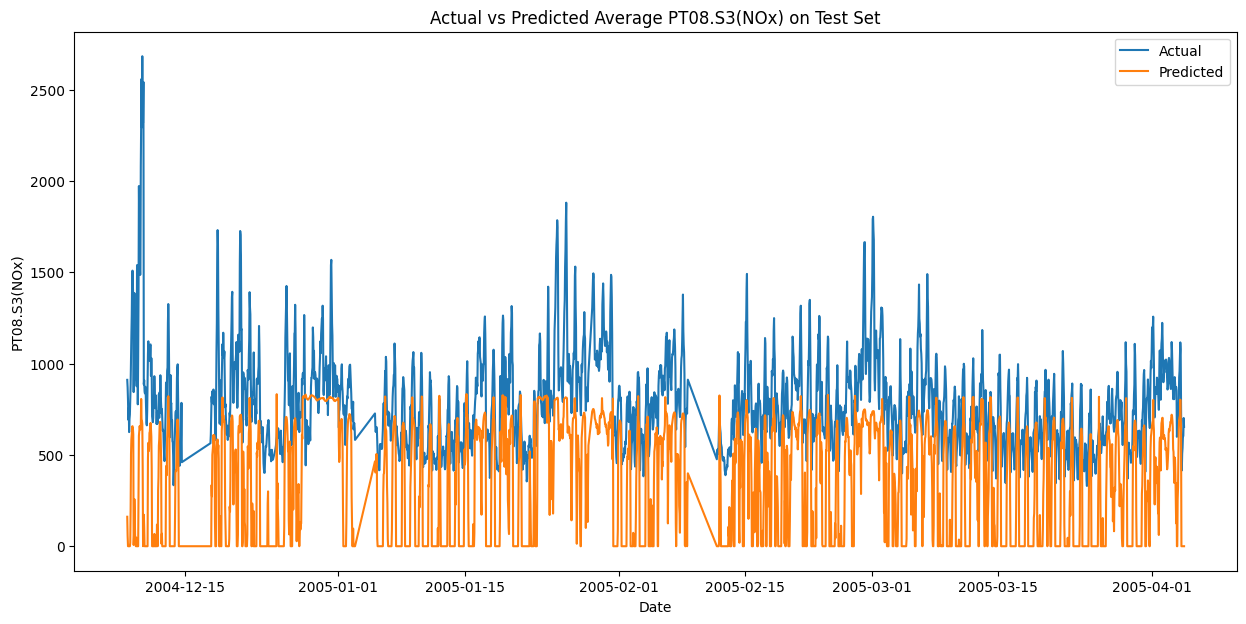

,Mean,Std. Dev.,Min,25%,Median,75%,Max
MultiRNN H32 AirQuality,442.61,205.78,0.15,298.05,445.22,567.00,2431.16


In [9]:
from util import get_predictions
r3 = get_predictions(raw_test=raw_test[~raw_test.index.isin(dropped_indices)], 
                     preprocessed_test=processed_test, 
                     results=airquality_results_multirnn_h32, 
                     model_name='MultiRNN H32 AirQuality',
                     xlabel='Date',
                     ylabel='PT08.S3(NOx)',
                     title='Actual vs Predicted Average PT08.S3(NOx) on Test Set',
                     target_feature_name='PT08.S3(NOx)',
                     save_path='../images/airquality-multirnn-h32-actual-vs-predicted.pdf',
                     show_plot=True,
                     zero_values=True)
r3                     

/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


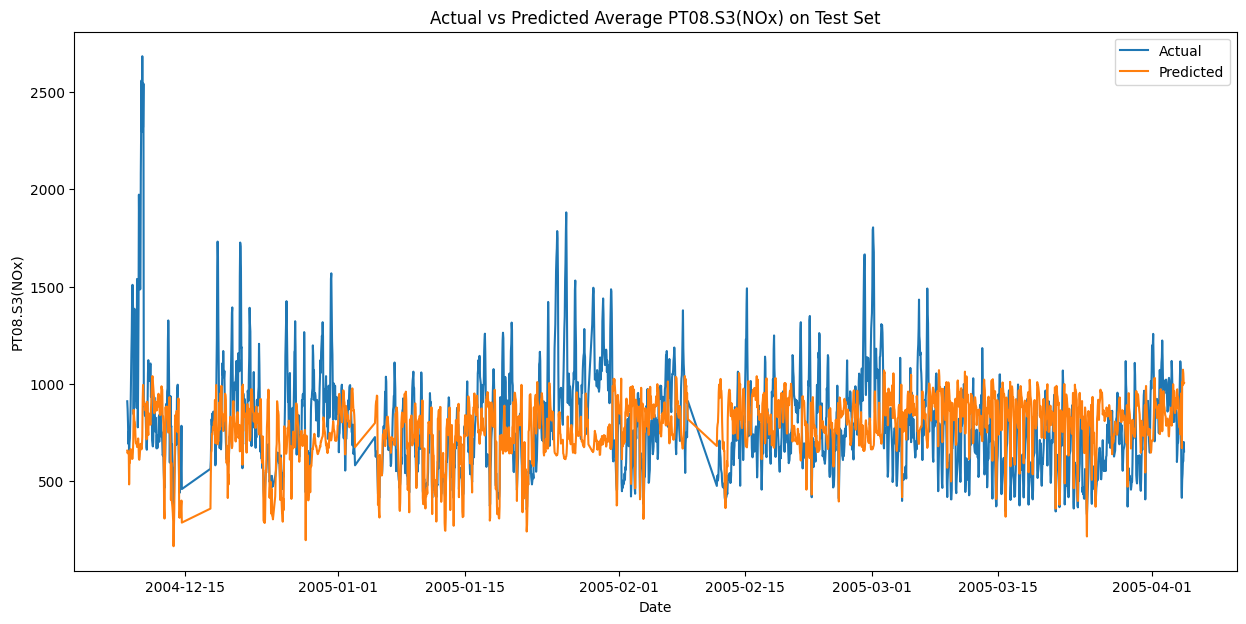

/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


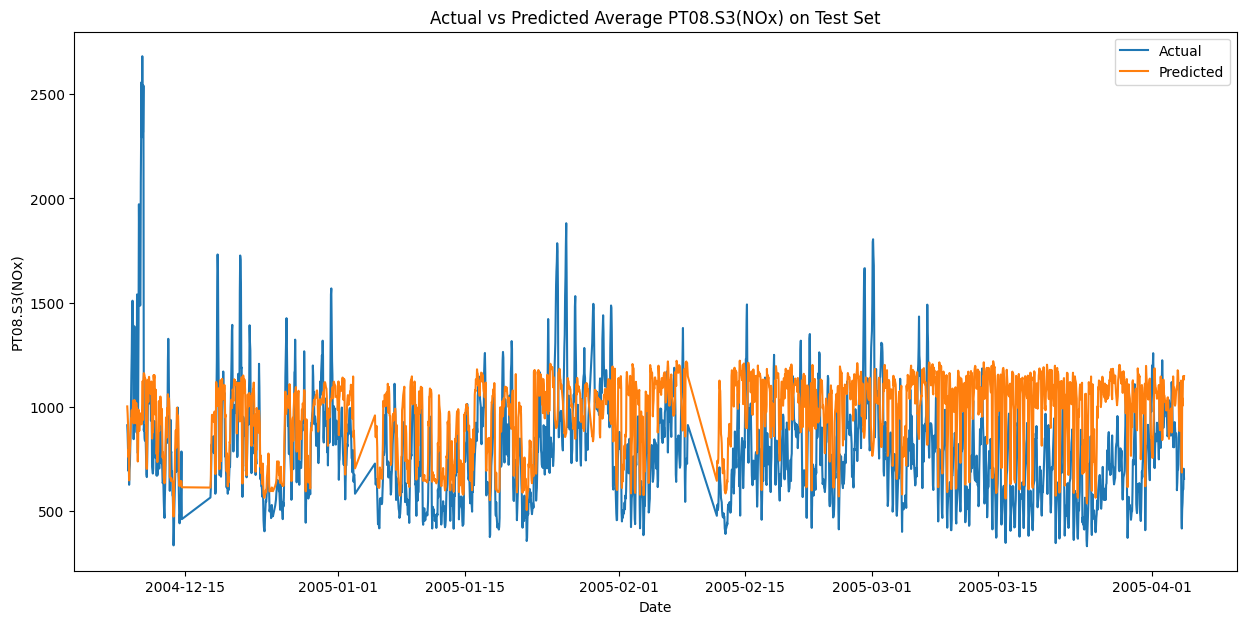

,Mean,Std. Dev.,Min,25%,Median,75%,Max
JordanRNN H32 AirQuality,220.80,192.22,0.27,89.03,185.88,299.65,1954.35
ElmanRNN H32 AirQuality,256.09,169.88,1.14,134.82,223.82,365.41,1670.03


In [86]:
from util import get_predictions

r1 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=airquality_jordan_h32_results, 
                     model_name='JordanRNN H32 AirQuality',
                     xlabel='Date',
                     ylabel='PT08.S3(NOx)',
                     title='Actual vs Predicted Average PT08.S3(NOx) on Test Set',
                     target_feature_name='PT08.S3(NOx)',
                     save_path='../images/airquality-jordan-h32-actual-vs-predicted.pdf',
                     show_plot=True)
r2 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=airquality_elman_h32_results, 
                     model_name='ElmanRNN H32 AirQuality',
                     xlabel='Date',
                     ylabel='PT08.S3(NOx)',
                     target_feature_name='PT08.S3(NOx)',
                     title='Actual vs Predicted Average PT08.S3(NOx) on Test Set',
                     save_path='../images/airquality-elman-h32-actual-vs-predicted.pdf',
                     show_plot=True)
results = pd.concat([r1, r2])
results.round(2).to_csv('../csv-descriptions/airquality-rnn-results-raw.csv', index=False)
results.round(2)